<a href="https://colab.research.google.com/github/JanLeyva/DeepLearning/blob/main/FacialPointDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2
## Facial Point Detection
By: Jan Leyva Massagué

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.

> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

In [ ]:
# downloading data
%%time
%matplotlib inline

import numpy as np
import matplotlib

import matplotlib.pyplot as plt

import os
import time
import cv2


from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from math import sin, cos, pi
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from keras.layers import Conv2D, LeakyReLU, GlobalAveragePooling2D, Dropout, Dense, Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, MaxPool2D, ZeroPadding2D
from keras.models import Sequential
from keras import layers, callbacks, utils, applications, optimizers


from keras.layers.advanced_activations import ReLU
from keras.models import Sequential, Model

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

CPU times: user 1.11 ms, sys: 0 ns, total: 1.11 ms
Wall time: 1.12 ms


In [ ]:
%%time
dropbox = False

if dropbox:
  !wget https://www.dropbox.com/s/svrvpus93131m98/test.csv
  !wget https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv
  FTRAIN = 'training.csv'
  FTEST = 'test.csv'
  FLOOKUP = 'IdLookupTable.csv'
else:
  from google.colab import drive
  drive.mount('/content/drive')
  FTRAIN = "/content/drive/MyDrive/dataset/training.csv"
  FTEST = "/content/drive/MyDrive/dataset/test.csv"

Mounted at /content/drive
CPU times: user 747 ms, sys: 191 ms, total: 938 ms
Wall time: 16.6 s


In [ ]:
def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        # y = (y - 48) / 48  # scale target coordinates to [-1, 1] // # we will rescale to [-1, 1] later
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y

## Plot function

In [ ]:
def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    plt.imshow(x, cmap='gray')
    plt.scatter(y[0::2], y[1::2], marker='x', s=10)

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

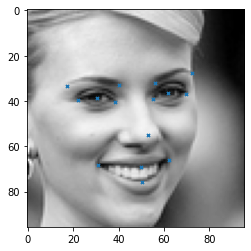

In [ ]:
# loading data and checking it

X, y = load()
plot_sample(X[12],y[12])

In [ ]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)
print("Train shape:{}".format(x_train.shape))
print("Test shape:{}".format(x_test.shape))
print("Valid shape:{}".format(x_valid.shape))

Train shape:(1498, 96, 96)
Test shape:(321, 96, 96)
Valid shape:(321, 96, 96)


### We must reshape the dataset- Keras requirement

In [ ]:
# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

In [ ]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

# Data Augmentation

In [ ]:
class parameters:
    rotation_angles = [12]
    pixel_shifts = [12]
    indexPhoto = 100

## Rotation

In [ ]:
def rotate_augmentation(images, keypoints, rotation_angles):
    rotated_images = []
    rotated_keypoints = []
    for angle in rotation_angles:
        for angle in [angle, -angle]:
            M = cv2.getRotationMatrix2D((48,48), angle, 1.)
            angle_rad = -angle*pi/180.
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.
                for idx in range(0, len(rotated_keypoint), 2):
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

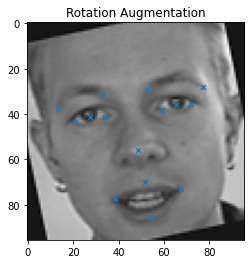

In [ ]:
rotated_train_images, rotated_train_keypoints = rotate_augmentation(x_train, y_train, parameters.rotation_angles)
train_images = np.concatenate((x_train, rotated_train_images))
train_keypoints = np.concatenate((y_train, rotated_train_keypoints))
fig, axis = plt.subplots()
plot_sample(rotated_train_images[parameters.indexPhoto], rotated_train_keypoints[parameters.indexPhoto], axis, "Rotation Augmentation")

In [ ]:
print("Shape of training dataset:",train_images.shape)
print("Shape of keypoints dataset:",train_keypoints.shape)

Shape of training dataset: (4494, 96, 96, 1)
Shape of keypoints dataset: (4494, 30)


## Change Brightness¶


In [ ]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)    
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))

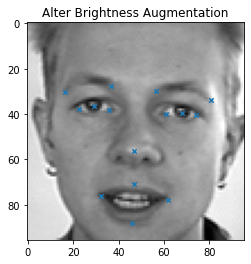

In [ ]:
altered_brightness_images, altered_brightness_keypoints = alter_brightness(x_train, y_train)
train_images = np.concatenate((train_images, altered_brightness_images))
train_keypoints = np.concatenate((train_keypoints, altered_brightness_keypoints))
fig, axis = plt.subplots()
plot_sample(altered_brightness_images[parameters.indexPhoto], altered_brightness_keypoints[parameters.indexPhoto], axis, "Alter Brightness Augmentation")

In [ ]:
print("Shape of training dataset:",train_images.shape)
print("Shape of keypoints dataset:",train_keypoints.shape)

Shape of training dataset: (7490, 96, 96, 1)
Shape of keypoints dataset: (7490, 30)


## Shift images


In [ ]:
def shift_images(images, keypoints, pixel_shifts):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints

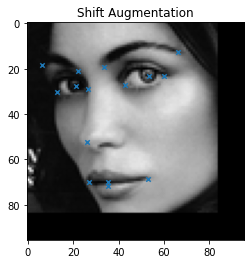

In [ ]:
shifted_train_images, shifted_train_keypoints = shift_images(x_train, y_train, parameters.pixel_shifts)
train_images = np.concatenate((train_images, shifted_train_images))
train_keypoints = np.concatenate((train_keypoints, shifted_train_keypoints))
fig, axis = plt.subplots()
plot_sample(shifted_train_images[parameters.indexPhoto], shifted_train_keypoints[parameters.indexPhoto], axis, "Shift Augmentation")

In [ ]:
print("Shape of training dataset:",train_images.shape)
print("Shape of keypoints dataset:",train_keypoints.shape)

Shape of training dataset: (11928, 96, 96, 1)
Shape of keypoints dataset: (11928, 30)


## Add noise


In [ ]:
def add_noise(images):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1).astype('float32'))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    return noisy_images

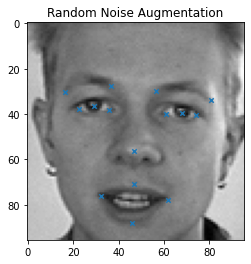

In [ ]:
noisy_train_images = add_noise(x_train)
train_images = np.concatenate((train_images, noisy_train_images))
train_keypoints = np.concatenate((train_keypoints, y_train))
fig, axis = plt.subplots()
plot_sample(noisy_train_images[ parameters.indexPhoto ], y_train[ parameters.indexPhoto ], axis, "Random Noise Augmentation")

## All data augmentation

Rotation Augmentation: 


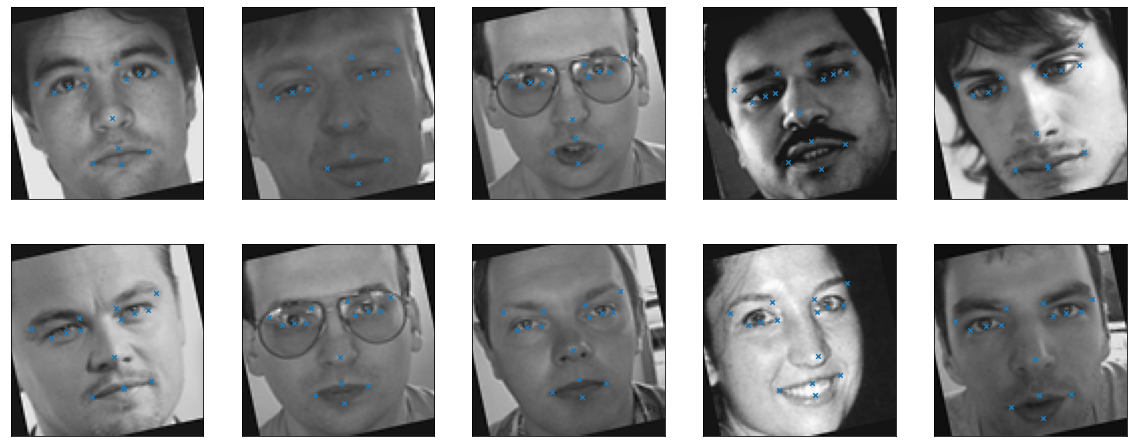

Brightness Augmentation: 


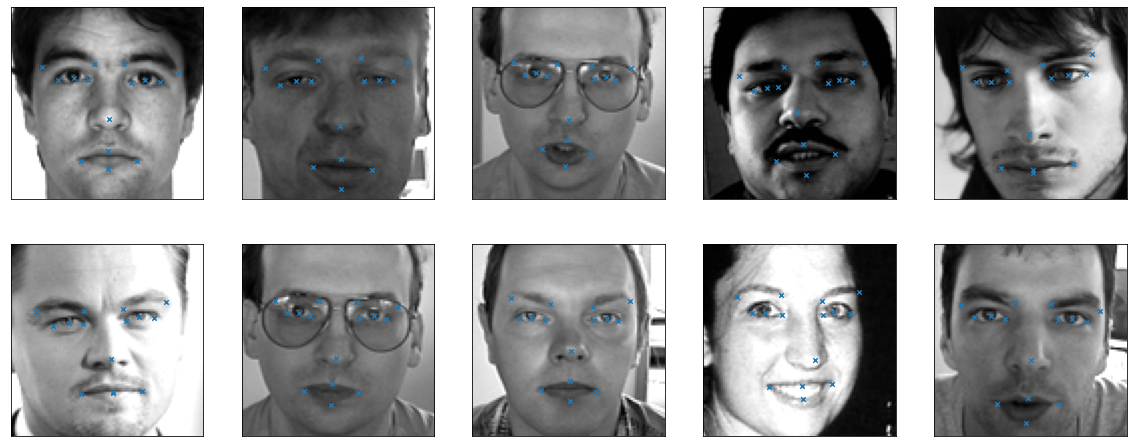

Shift Augmentation: 


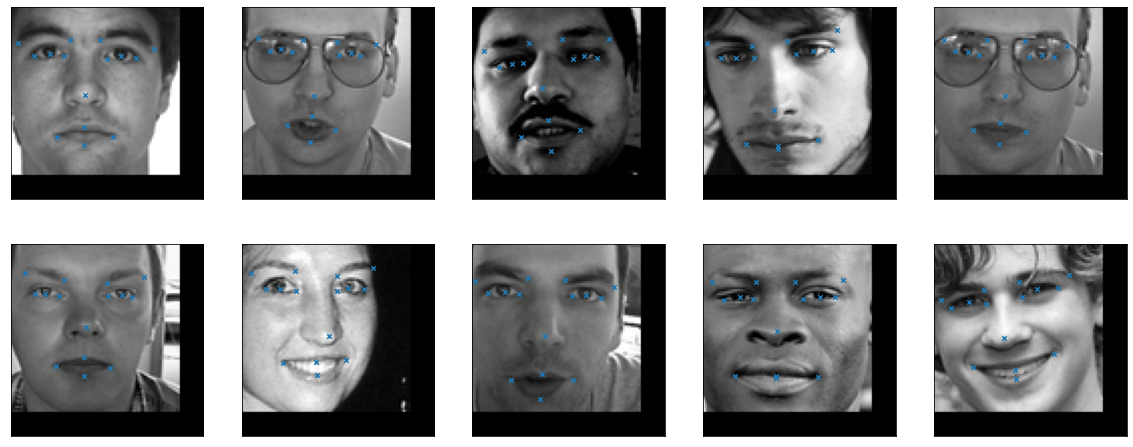

Random Noise Augmentation: 


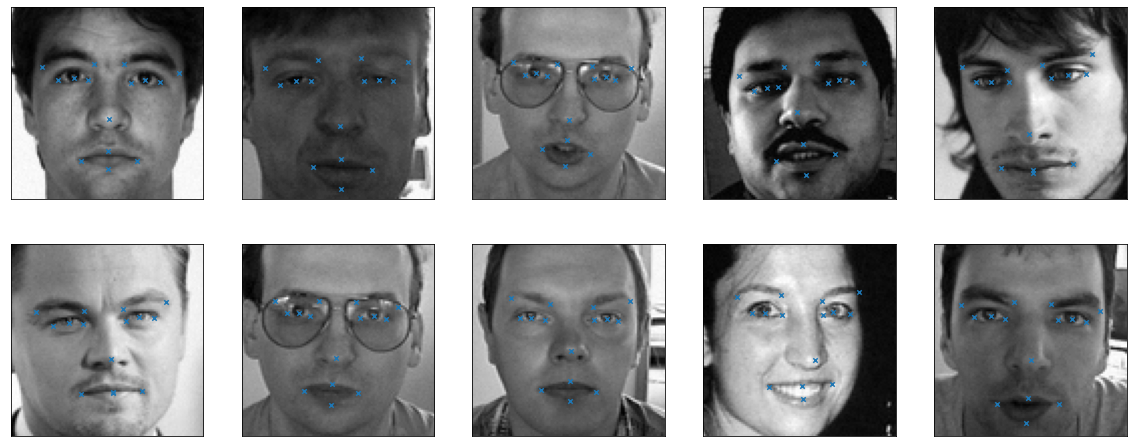

In [ ]:
print("Rotation Augmentation: ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(rotated_train_images[i], rotated_train_keypoints[i], axis, "")
plt.show()

print("Brightness Augmentation: ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(altered_brightness_images[i], altered_brightness_keypoints[i], axis, "")
plt.show()

print("Shift Augmentation: ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(shifted_train_images[i], shifted_train_keypoints[i], axis, "")
plt.show()

print("Random Noise Augmentation: ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(noisy_train_images[i], y_train[i], axis, "")
plt.show()

In [ ]:
print("Shape of training dataset:",x_train.shape)
print("Shape of keypoints dataset:",y_train.shape)

Shape of training dataset: (1498, 96, 96, 1)
Shape of keypoints dataset: (1498, 30)


In [ ]:
print("Shape of training dataset:",train_images.shape)
print("Shape of keypoints dataset:",train_keypoints.shape)

Shape of training dataset: (13438, 96, 96, 1)
Shape of keypoints dataset: (13438, 30)


In [ ]:
print("The dataset augmented",len(train_images)-len(x_train), "mores images.")

The dataset augmented 11940 mores images.


# Model


### We rescale keypoints [-1,1]

In [ ]:
#y_train = (y_train-48)/48
train_keypoints = (train_keypoints-48) / 48
y_valid = (y_valid-48)/48

## 1st Model - baseline + Data augmentation

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 30)                1105950   
Total params: 1,143,518
Trainable params: 1,143,518
Non-trainable params: 0
______________________________________________

In [ ]:
batch_size = 128
epochs = 50

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer="adam")

model.fit(train_images, train_keypoints, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
105/105 [==============================] - 40s 92ms/step - loss: 0.1228 - val_loss: 0.0567
Epoch 2/50
105/105 [==============================] - 9s 85ms/step - loss: 0.0536 - val_loss: 0.0392
Epoch 3/50
105/105 [==============================] - 9s 84ms/step - loss: 0.0465 - val_loss: 0.0339
Epoch 4/50
105/105 [==============================] - 9s 83ms/step - loss: 0.0417 - val_loss: 0.0411
Epoch 5/50
105/105 [==============================] - 9s 86ms/step - loss: 0.0400 - val_loss: 0.0313
Epoch 6/50
105/105 [==============================] - 9s 86ms/step - loss: 0.0369 - val_loss: 0.0250
Epoch 7/50
105/105 [==============================] - 9s 86ms/step - loss: 0.0352 - val_loss: 0.0229
Epoch 8/50
105/105 [==============================] - 9s 86ms/step - loss: 0.0339 - val_loss: 0.0235
Epoch 9/50
105/105 [==============================] - 9s 87ms/step - loss: 0.0334 - val_loss: 0.0227
Epoch 10/50
105/105 [==============================] - 9s 84ms/step - loss: 0.0314 - val_l

In [ ]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square((y_pred*48) - (y_true*48))))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

Mean pixel error:  2.1889272


# 2nd Model - CNN + change learning rate

In [ ]:
# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

modelCNN = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(output_shape, activation="linear"),
    ]
)

modelCNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 30)                1

In [ ]:
batch_size = 128
epochs = 50

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))


es = callbacks.EarlyStopping(
    monitor='loss', patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, mode='min', verbose=1
)


# optimizer = keras.optimizers.Adam(lr=0.01)

modelCNN.compile(loss=root_mean_squared_error, optimizer="adam")

modelCNN.fit(train_images, train_keypoints, batch_size=batch_size, epochs=epochs, validation_split=0.1,
            callbacks=[es, rlp] )

Epoch 1/50
95/95 [==============================] - 218s 2s/step - loss: 0.1206 - val_loss: 0.0576
Epoch 2/50
12/95 [==>...........................] - ETA: 3:04 - loss: 0.0628

In [ ]:
# Change learning rate to 0.001 and train for 50 more epochs
K.set_value(modelCNN.optimizer.learning_rate, 0.001)
modelCNN.fit( train_images , 
          train_keypoints, 
          initial_epoch=50, 
          epochs=50,
          verbose=0, validation_split=0.1,
            callbacks=[es, rlp])

In [ ]:
y_newCNN = modelCNN.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square((y_pred*48) - (y_true*48))))

print("Mean pixel error: ", rmse_pixel(y_valid, y_newCNN))

Mean pixel error:  2.0893035


# 3rd Model-CNN with dropout

In [ ]:
modelCNN2 = Sequential()

modelCNN2.add(Convolution2D(32, (3,3), activation = 'relu', padding='same', use_bias=False, input_shape=(96,96,1)))
modelCNN2.add(MaxPool2D(pool_size=(2, 2)))

modelCNN2.add(Convolution2D(32, (3,3), activation = 'relu', padding='same', use_bias=False))
modelCNN2.add(MaxPool2D(pool_size=(2, 2)))

modelCNN2.add(Convolution2D(64, (3,3), activation = 'relu', padding='same', use_bias=False))
modelCNN2.add(MaxPool2D(pool_size=(2, 2)))

modelCNN2.add(Convolution2D(128, (3,3), activation = 'relu', padding='same', use_bias=False))
modelCNN2.add(MaxPool2D(pool_size=(2, 2)))


modelCNN2.add(Flatten())
modelCNN2.add(Dense(256,activation='relu'))
modelCNN2.add(Dropout(0.1))
modelCNN2.add(Dense(30))
modelCNN2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 48, 48, 32)        9216      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 64)        18432     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 128)      

In [ ]:
modelCNN2.compile(optimizer='adam', 
              loss= root_mean_squared_error,
              metrics=['acc'])

modelCNN2.fit(train_images, train_keypoints, epochs = 50, batch_size = 128,validation_split = 0.1)

Epoch 1/50
105/105 [==============================] - 7s 57ms/step - loss: 0.0389 - acc: 0.8165 - val_loss: 0.0230 - val_acc: 0.8465
Epoch 2/50
105/105 [==============================] - 6s 53ms/step - loss: 0.0363 - acc: 0.8286 - val_loss: 0.0223 - val_acc: 0.8525
Epoch 3/50
105/105 [==============================] - 6s 54ms/step - loss: 0.0353 - acc: 0.8335 - val_loss: 0.0233 - val_acc: 0.8572
Epoch 4/50
105/105 [==============================] - 6s 54ms/step - loss: 0.0349 - acc: 0.8362 - val_loss: 0.0226 - val_acc: 0.8727
Epoch 5/50
105/105 [==============================] - 6s 54ms/step - loss: 0.0342 - acc: 0.8386 - val_loss: 0.0203 - val_acc: 0.8680
Epoch 6/50
105/105 [==============================] - 6s 54ms/step - loss: 0.0333 - acc: 0.8466 - val_loss: 0.0203 - val_acc: 0.8653
Epoch 7/50
105/105 [==============================] - 6s 54ms/step - loss: 0.0331 - acc: 0.8465 - val_loss: 0.0198 - val_acc: 0.8700
Epoch 8/50
105/105 [==============================] - 6s 54ms/step - 

In [ ]:
y_newCNN2 = modelCNN2.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square((y_pred*48) - (y_true*48))))

print("Mean pixel error: ", rmse_pixel(y_valid, y_newCNN2))

Mean pixel error:  1.3192995


# 4th Model - MobileNet

In [ ]:
model2 = Sequential()
pretrained_model = MobileNet(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model2.add(Conv2D(3, (1,1), padding='same', input_shape=(96,96,1)))
model2.add(LeakyReLU(alpha=0.1))
model2.add(pretrained_model)
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.1))
model2.add(Dense(30))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 3)         6         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 3, 3, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                30750     
Total params: 3,259,620
Trainable params: 3,237,732
Non-trainable params: 21,888
_______________________________________

## Training the pre-trained MobileNet

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='loss', patience=30, mode='min',
                             baseline=None)


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))


# model2.compile(loss=root_mean_squared_error, optimizer="adam")

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)

model2.compile(optimizer='adam', loss=root_mean_squared_error, metrics=['accuracy'])

history = model2.fit(train_images, train_keypoints, epochs=20, batch_size=128, validation_split=0.1, callbacks=[earlyStopping, rlp])

Epoch 1/20
95/95 [==============================] - 29s 257ms/step - loss: 0.3420 - accuracy: 0.3721 - val_loss: 0.8559 - val_accuracy: 0.4628
Epoch 2/20
95/95 [==============================] - 23s 242ms/step - loss: 0.0862 - accuracy: 0.6532 - val_loss: 0.6378 - val_accuracy: 0.4710
Epoch 3/20
95/95 [==============================] - 23s 244ms/step - loss: 0.0655 - accuracy: 0.7120 - val_loss: 0.2969 - val_accuracy: 0.7225
Epoch 4/20
95/95 [==============================] - 23s 241ms/step - loss: 0.0561 - accuracy: 0.7442 - val_loss: 0.1602 - val_accuracy: 0.7440
Epoch 5/20
95/95 [==============================] - 23s 243ms/step - loss: 0.0525 - accuracy: 0.7660 - val_loss: 0.0874 - val_accuracy: 0.7374
Epoch 6/20
95/95 [==============================] - 23s 241ms/step - loss: 0.0460 - accuracy: 0.7823 - val_loss: 0.0637 - val_accuracy: 0.7560
Epoch 7/20
95/95 [==============================] - 23s 241ms/step - loss: 0.0436 - accuracy: 0.8030 - val_loss: 0.0585 - val_accuracy: 0.7835

In [ ]:
y_new2 = model2.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square((y_pred*48) - (y_true*48))))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new2))

Mean pixel error:  1.4694103


# 5th Model-ResNet50

In [ ]:
model_ResNet = Sequential()

pretrained_model = tf.keras.applications.ResNet50(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model_ResNet.add(layers.Convolution2D(3, (1, 1), padding='same', input_shape=(96,96,1)))
model_ResNet.add(layers.LeakyReLU(alpha = 0.1))
model_ResNet.add(pretrained_model)
model_ResNet.add(layers.GlobalAveragePooling2D())
model_ResNet.add(layers.Dropout(0.1))
model_ResNet.add(layers.Dense(30))
model_ResNet.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 96, 96, 3)         6         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 96, 96, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                61470     
Total params: 23,649,188
Trainable params: 23,596,068
N

In [ ]:
es = callbacks.EarlyStopping(
    monitor='loss', patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-15, mode='min', verbose=1
)

model_ResNet.compile(
    optimizer='adam', loss= root_mean_squared_error , metrics=['mae', 'acc']
)

history = model_ResNet.fit(
    train_images, train_keypoints, epochs=50, batch_size=batch_size, 
    validation_split=0.1, callbacks=[es, rlp]
)

Epoch 1/50
95/95 [==============================] - 61s 576ms/step - loss: 0.0327 - mae: 0.0250 - acc: 0.8615 - val_loss: 0.0577 - val_mae: 0.0443 - val_acc: 0.7299
Epoch 2/50
95/95 [==============================] - 54s 566ms/step - loss: 0.0288 - mae: 0.0220 - acc: 0.8752 - val_loss: 0.0452 - val_mae: 0.0336 - val_acc: 0.7969
Epoch 3/50
95/95 [==============================] - 54s 566ms/step - loss: 0.0280 - mae: 0.0214 - acc: 0.8736 - val_loss: 0.0429 - val_mae: 0.0339 - val_acc: 0.8036
Epoch 4/50
95/95 [==============================] - 54s 567ms/step - loss: 0.0273 - mae: 0.0209 - acc: 0.8757 - val_loss: 0.0345 - val_mae: 0.0266 - val_acc: 0.8348
Epoch 5/50
95/95 [==============================] - 55s 575ms/step - loss: 0.0263 - mae: 0.0202 - acc: 0.8818 - val_loss: 0.0431 - val_mae: 0.0346 - val_acc: 0.8274
Epoch 6/50
95/95 [==============================] - 54s 567ms/step - loss: 0.0258 - mae: 0.0198 - acc: 0.8905 - val_loss: 0.0682 - val_mae: 0.0509 - val_acc: 0.6726
Epoch 7/50

In [ ]:
y_new_ResNet = model_ResNet.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square((y_pred*48) - (y_true*48))))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new_ResNet))

Mean pixel error:  1.0305785


# Visualize the predictions in Validate data ResNet 50

In [ ]:
def plot_results(x, y, y_true):
    """
    Plots a single sample image with keypoints on top.   
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10, c = "#FF0000")
    pyplot.scatter(y_true[0::2] * 48 + 48, y_true[1::2] * 48 + 48, marker='o', s=10, c = "#7CFC00")

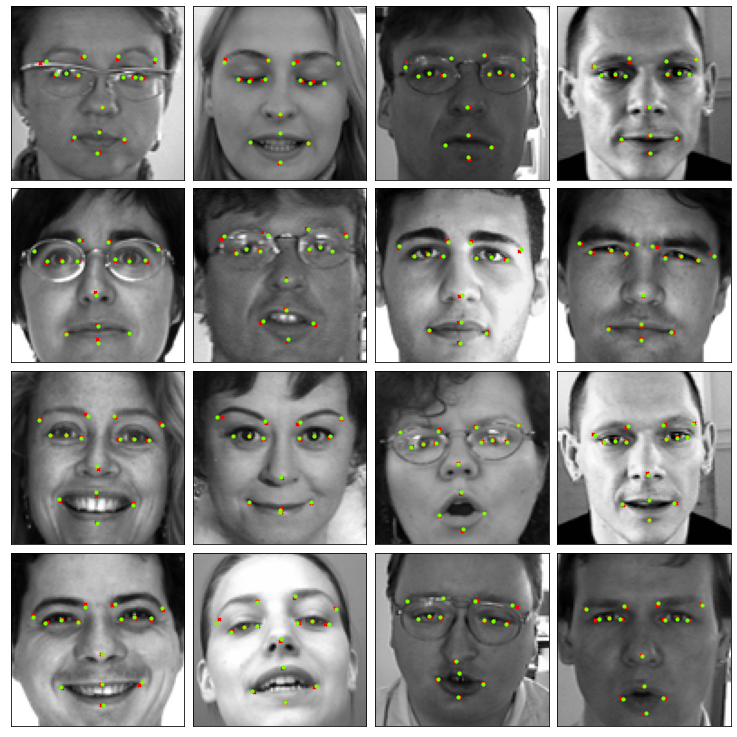

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_results(x_valid[i,:,:,0],y_new_ResNet[i], y_valid[i])

pyplot.show()

# Reporting

## Results

|  Model | Mean Error  |   |   |   |
|---|---|---|---|---|
|  Baseline model| 2.18  |  |   |   |
|  Baseline + change learning rate | 2.10   |   |   |   |
|  CNN + dropout | 1.31   |   |   |   |
| MobileNet  |  1.47 |   |   |   |
|  ResNet50 |  1.03 |   |   |   |



## Procedure


First problem for this aproach was that we had not enough data to do a good performance for the models. For this reason we did a **data augmentation**, using diferent techniques as shift augmentation, brigthness etc.

Once we had the enough data we start trying different architectures and techniques in order to catch a good result for the model. The first model, was implementing a callbacks to the `baseline` archirecture such as change learning rate and keep the best weights with `ReduceLROnPlateau` function. But, this techniques with the baseline model seems to do not work.

Then, we try add a dropout layer to the end of the architecture with this we get a really good results too (1.31 mean error). 

The model implemented are:    
- Baseline + changing learning rate: I though that if we change the learning rate as long as the model learn we could catch a better performance, but I was wrong.

- CNN + Dropout:   We change the CNN architecture a little bit and add a final `Dropout` between the last two dense layers. This perfom really good for this task.

- MobileNet: We transfer the learning from the pre-trained model MobileNet. This pre-trained model is trained with ImageNet dataset, but in this case this model solve task across a wide range of applications and use cases including object detection, finegrain classification, face attributes and large scale geo-localization. We use the ImageNet weights and training the final part in our dataset, also adding a Dropout = 0.1 at the final layers.

- ResNet50:    As in the previous case we used a pre-trained model, in this case the winner architecture for the ImageNet challange in 2015. We used the weight from ImageNet and trained the last part of the model, adding a callbacks and a dropout in the last layers. This architecture got the best result in this dataset and task.



## What is the best result you got when testing?  

**Answer**: The mean pixel error is 1.03 with ResNet 50 pre-trained architecure. But in CNN with a Dropout also catch a good result 1.31.

## What architecture and tricks you used for that result?
The final architecture is a ResNet50 (pre-trained model) that we adapt to our task.
- ResNet is the winner architecture for the ImageNet challange in 2015. This Deep architecture pretrained with the famous ImageNet dataset will be usefull for us, because is an architecture specialized in computer vision that this will help us to identify faces and his keypoints in less effort than a simple cnn.

Nowdays in deep learning is usual use a pre-trained architectures in order to use all the learn that the previous architecture catch from a big corpus dataset and implement it to a concret task with smaller datasets.

- CNN-dropout, we use a architecture that use a convolutional neural network and in the last layer between two last dense layers do a `dropout = 0.1`. This model works really well for this task.


## Describe your design strategy as well all those tricks that contributed to your result.

**Answer**: The thing that really help me more to get a good result is the last layer dropout(0.1), because I can do the comparation with the baseline and the callbacks extras as learning rate change during the training do not help to improve the score. As well, the pre-trained models give an extra learning to our model in order to get a 1.03 mean error, that is a good result with only 50 epochs.

## Future work

In order to get a better results will be good do data augmentation to all dataset not only the train, then we could train the best model [ResNet50] with all dataset augmented and with a few more epochs such as (100, 150, 300) and check if this implemantion work better than the one that we use now.